# Proyek Klasifikasi Gambar: KITTI Object Detection

Notebook ini mencakup pipeline lengkap untuk melatih klasifikasi gambar 'Car', 'Pedestrian', 'Cyclist', dan 'Van' menggunakan dataset KITTI.

**Fitur:**
1.  **Data Loading & Augmentation**: Menggunakan `ImageDataGenerator`.
2.  **Model Architecture**: Sequential CNN dengan `Conv2D` dan `MaxPooling`.
3.  **Training**: Menggunakan Callbacks (`EarlyStopping`, `ModelCheckpoint`).
4.  **Evaluation**: Plot Akurasi dan Loss.
5.  **Inference**: Uji coba prediksi pada data baru.
6.  **Model Conversion**: Konversi ke SavedModel, TF-Lite, dan TFJS.

---

## 1. Import Library & Konfigurasi

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# Konfigurasi Path
BASE_DIR = 'data_split'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameter Gambar
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 2. Data Preparation (Augmentation)

In [2]:
# Augmentasi untuk data Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation hanya di-rescale
validation_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Multiclass (Kriteria: Dataset Splitting)
)

print("Loading Validation Data...")
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

CLASSES = list(train_generator.class_indices.keys())
print(f"Classes: {CLASSES}")

Loading Training Data...
Found 8934 images belonging to 4 classes.
Loading Validation Data...
Found 1115 images belonging to 4 classes.
Classes: ['car', 'cyclist', 'pedestrian', 'van']


## 3. Membangun Arsitektur Model (CNN)

In [3]:
model = Sequential([ # Kriteria: Model Sequential CNN
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu'), # Kriteria: Conv2D Layer
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Flatten & Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    # Output Layer (4 Kelas: Car, Cyclist, Pedestrian, Van)
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Training (Dengan Callbacks)

In [4]:
# Callbacks
callbacks = [
    # Hentikan training jika val_accuracy tidak naik selama 5 epochs
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True), # Kriteria: Accuracy > 85% monitored
    # Simpan model terbaik
    tf.keras.callbacks.ModelCheckpoint('saved_model/model_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Starting Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Starting Training...
Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7958 - loss: 0.6606  
Epoch 1: val_accuracy improved from None to 0.83456, saving model to saved_model/model_best.h5



Epoch 1: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 80s 283ms/step - accuracy: 0.8266 - loss: 0.5403 - val_accuracy: 0.8346 - val_loss: 0.4771
Epoch 2/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 1:13 263ms/step - accuracy: 0.8750 - loss: 0.4610
Epoch 2: val_accuracy did not improve from 0.83456
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8750 - loss: 0.4610 - val_accuracy: 0.8281 - val_loss: 0.4779
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8622 - loss: 0.4067  
Epoch 3: val_accuracy improved from 0.83456 to 0.87408, saving model to saved_model/model_best.h5



Epoch 3: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 75s 268ms/step - accuracy: 0.8721 - loss: 0.3741 - val_accuracy: 0.8741 - val_loss: 0.2961
Epoch 4/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.8333 - loss: 0.1452
Epoch 4: val_accuracy did not improve from 0.87408
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8333 - loss: 0.1452 - val_accuracy: 0.8676 - val_loss: 0.3171
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8845 - loss: 0.3361  
Epoch 5: val_accuracy improved from 0.87408 to 0.90625, saving model to saved_model/model_best.h5



Epoch 5: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 71s 255ms/step - accuracy: 0.8836 - loss: 0.3342 - val_accuracy: 0.9062 - val_loss: 0.2300
Epoch 6/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 1:05 234ms/step - accuracy: 0.9062 - loss: 0.3127
Epoch 6: val_accuracy improved from 0.90625 to 0.91268, saving model to saved_model/model_best.h5



Epoch 6: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9062 - loss: 0.3127 - val_accuracy: 0.9127 - val_loss: 0.2202
Epoch 7/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9067 - loss: 0.2720  
Epoch 7: val_accuracy improved from 0.91268 to 0.93750, saving model to saved_model/model_best.h5



Epoch 7: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 71s 255ms/step - accuracy: 0.9002 - loss: 0.2855 - val_accuracy: 0.9375 - val_loss: 0.1687
Epoch 8/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 1:05 236ms/step - accuracy: 0.9688 - loss: 0.1933
Epoch 8: val_accuracy improved from 0.93750 to 0.94210, saving model to saved_model/model_best.h5



Epoch 8: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9688 - loss: 0.1933 - val_accuracy: 0.9421 - val_loss: 0.1630
Epoch 9/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9122 - loss: 0.2642  
Epoch 9: val_accuracy improved from 0.94210 to 0.94393, saving model to saved_model/model_best.h5



Epoch 9: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 70s 251ms/step - accuracy: 0.9099 - loss: 0.2611 - val_accuracy: 0.9439 - val_loss: 0.1433
Epoch 10/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 1:04 233ms/step - accuracy: 0.9062 - loss: 0.1924
Epoch 10: val_accuracy did not improve from 0.94393
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9062 - loss: 0.1924 - val_accuracy: 0.9393 - val_loss: 0.1505


## 5. Evaluasi & Visualisasi

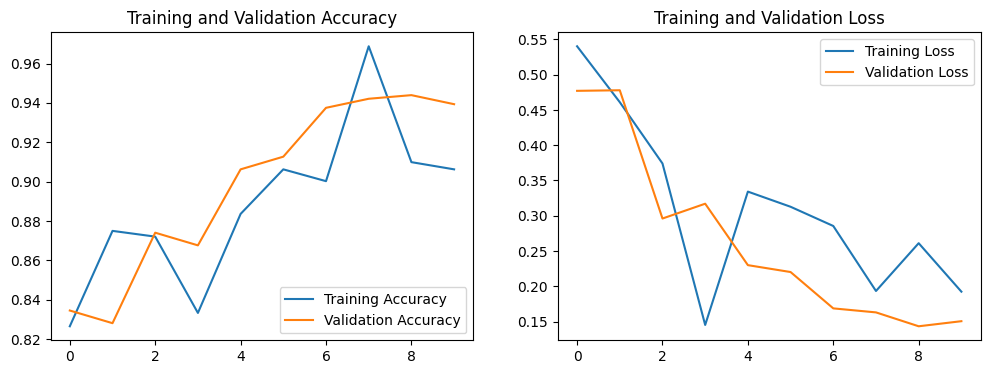

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy') # Kriteria: Plot Accuracy & Loss
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## 6. Inference (Uji Coba)
Mengambil satu gambar acak dari folder test.

Testing on: data_split/test/van/0093_011_000088.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


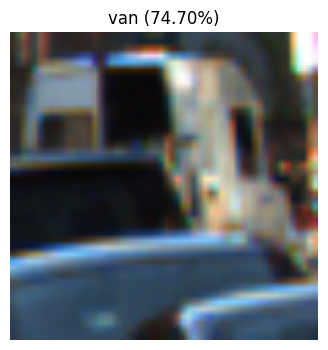

('van', np.float32(0.74695855))

In [6]:
def predict_image(img_path, model, classes):
    # Load & Preprocess
    img = image.load_img(img_path, target_size=TARGET_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Predict
    predictions = model.predict(img_array)
    idx = np.argmax(predictions)
    label = classes[idx]
    confidence = predictions[0][idx]

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"{label} ({confidence:.2%})")
    plt.axis('off')
    plt.show()
    return label, confidence

# Ambil contoh gambar dari test set
import random
test_class = random.choice(CLASSES)
test_dir_class = os.path.join(TEST_DIR, test_class)
test_img_name = random.choice(os.listdir(test_dir_class))
test_img_path = os.path.join(test_dir_class, test_img_name)

print(f"Testing on: {test_img_path}")
predict_image(test_img_path, model, CLASSES)

## 7. Konversi Model (SavedModel, TF-Lite, TFJS)

In [7]:
# Load Model Terbaik
best_model = load_model('saved_model/model_best.h5')

# 1. Save as SavedModel
saved_model = 'saved_model'
if os.path.exists(saved_model):
    shutil.rmtree(saved_model)
try:
    best_model.export(saved_model)
    print("✅ SavedModel exported successfully.")
except Exception as e:
    print(f"❌ SavedModel export failed: {e}")

# 2. Convert to TF-Lite
tflite_path = 'tflite/model_car_pedestrian.tflite'
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(best_model) # Kriteria: TF-Lite Conversion
    tflite_model = converter.convert()
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print(f"✅ TF-Lite model saved to {tflite_path}.")
except Exception as e:
    print(f"❌ TF-Lite conversion failed: {e}")

# 3. Convert to TFJS
tfjs_model = 'tfjs_model'
if os.path.exists(tfjs_model):
    shutil.rmtree(tfjs_model)
try:
    # Patch untuk numpy compatibility di notebook
    if not hasattr(np, 'object'):
        np.object = object
    import tensorflowjs as tfjs
    tfjs.converters.convert_tf_saved_model(saved_model, tfjs_model) # Kriteria: TFJS Conversion
    print(f"✅ TFJS model saved to {tfjs_model}.")
except Exception as e:
    print(f"❌ TFJS conversion failed: {e}")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  4934087312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934074448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934075024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934082128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934078864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934077904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934078480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934076944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934082320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934079824: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ SavedModel exported successfully.
INFO:tensorflow:Assets written to: /

INFO:tensorflow:Assets written to: /var/folders/6r/c477pvvd4bjd8pd3x3sj9_br0000gn/T/tmpm_6m9myc/assets


Saved artifact at '/var/folders/6r/c477pvvd4bjd8pd3x3sj9_br0000gn/T/tmpm_6m9myc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  4934087312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934074448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934075024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934082128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934078864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934077904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934078480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934076944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934082320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4934079824: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1768827313.026836  607840 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1768827313.026871  607840 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1768827313.072167  607840 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled


❌ TF-Lite conversion failed: [Errno 2] No such file or directory: 'tflite/model_car_pedestrian.tflite'


I0000 00:00:1768827317.231318  607840 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1768827317.231770  607840 single_machine.cc:376] Starting new session


Writing weight file tfjs_model/model.json...
✅ TFJS model saved to tfjs_model.
